In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [7]:
### Function to convert dataframe to timeseries object
def create_ts_object(df):
    df.Timestamp = pd.to_datetime(df.Timestamp)
    df.set_index("Timestamp", inplace=True)
    df = df.asfreq('H')

    return df.head()

### Import Digester 20 data

In [8]:
data20 = pd.read_csv("~/Documents/Data/FinalDatasetForModel/Digester20data.csv")
data20.drop(['Dig_20_woodload', 'Dig_20_Liq_circ',
       'Digester_20_temperature', 'Digester_20_pressure',
       'Dig_20_phase_Comm Fail', 'Dig_20_phase_Configure',
       'Dig_20_phase_HP GAS RELEASE', 'Dig_20_phase_LIQUOR LOADING',
       'Dig_20_phase_LP GAS RELEASE', 'Dig_20_phase_PULP DISCHARGE',
       'Dig_20_phase_READY FOR LIQUOR',
       'Dig_20_phase_READY FOR PULP DISCH',
       'Dig_20_phase_READY FOR STEAMING', 'Dig_20_phase_READY FOR WOOD',
       'Dig_20_phase_SFACTOR TGT REACHED',
       'Dig_20_phase_SMOOTH STEAM FIXED',
       'Dig_20_phase_SMOOTH STEAM RAMP', 'Dig_20_phase_Scan Timeout',
       'Dig_20_phase_TEMP RAMP TO 110C', 'Dig_20_phase_TEMP RAMP TO 126C',
       'Dig_20_phase_TEMP RAMP TO TMAX', 'Dig_20_phase_VALVE CHECK',
       'Dig_20_phase_WOODLOAD COMPLETE', 'Dig_20_phase_WOODLOADING', 'Dig_20_phase_PULP DISCH COMPLETE'], axis = 1, inplace=True)

create_ts_object(data20)

,Dig_20_HX
Timestamp,
2020-11-01 00:00:00,0.044137
2020-11-01 01:00:00,0.265619
2020-11-01 02:00:00,8.522645
2020-11-01 03:00:00,5.031488
2020-11-01 04:00:00,1.462747


### Stationarity

In [9]:
sts.adfuller(data20.Dig_20_HX)

(-9.173203100850623,
 2.3578029022599935e-15,
 19,
 2189,
 {'1%': -3.4333408565184294,
  '5%': -2.8628612620249507,
  '10%': -2.5674733728800154},
 11070.757894025255)

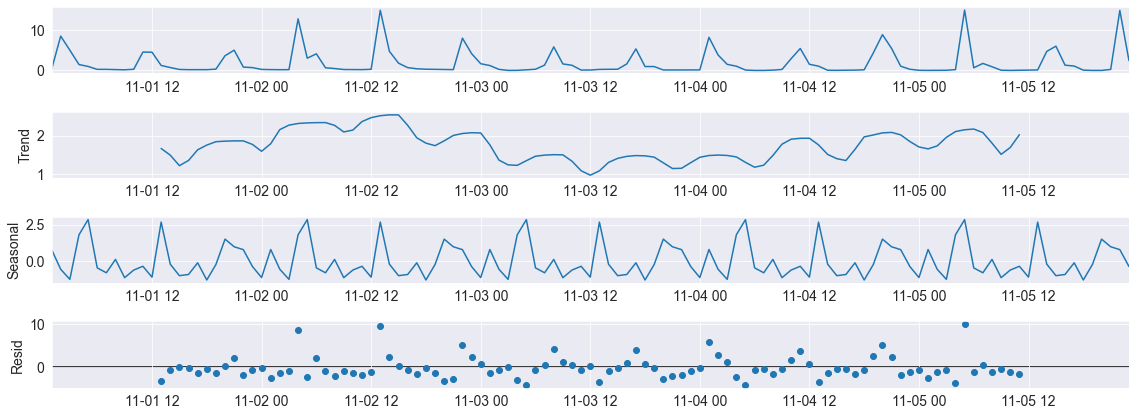

In [10]:
seas_dec = seasonal_decompose(data20[1:120], model = "additive")
seas_dec.plot()
plt.show()

### ACF

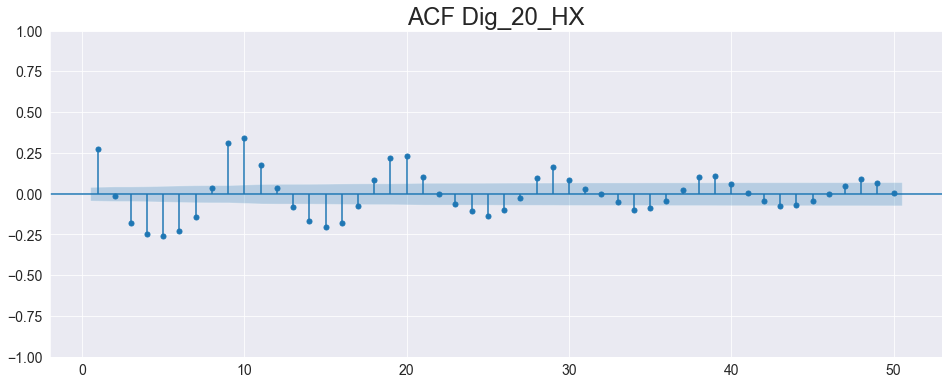

In [11]:
sgt.plot_acf(data20.Dig_20_HX, lags = 50, zero = False)
plt.title("ACF Dig_20_HX", size = 24)
plt.show()

### PACF

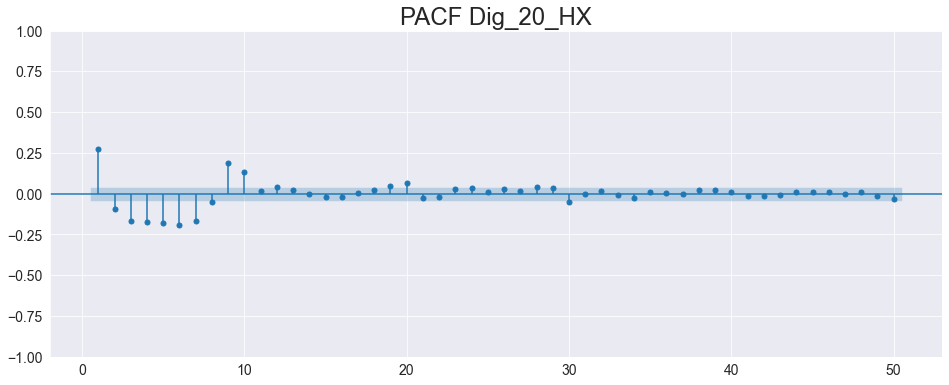

In [12]:
sgt.plot_pacf(data20.Dig_20_HX, lags = 50, zero = False, method = ('ols'))
plt.title("PACF Dig_20_HX", size = 24)
plt.show()

In [13]:
#  Spare copy
data20_twin1 = data20.copy()

### Normalization

In [14]:
# define functions to scale and reverse-scale data, looping through the columns, and passing a scaler type
def scale_data(data, scaler):
    for col in data.columns.values:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data.head()

In [15]:
scaler = MinMaxScaler()
data20_twin = data20.copy()
scale_data(data20_twin, scaler)

,Dig_20_HX
Timestamp,
2020-11-01 00:00:00,0.002942
2020-11-01 01:00:00,0.017708
2020-11-01 02:00:00,0.568176
2020-11-01 03:00:00,0.335433
2020-11-01 04:00:00,0.097516


### Data Split

In [16]:
train_size = int(len(data20_twin)*0.85)
val_size = train_size + int(len(data20_twin)*0.10)
train_data20 = data20_twin.iloc[:train_size]
val_data20 = data20_twin.iloc[train_size:val_size]
test_data20 = data20_twin.iloc[val_size:]

In [17]:
val_data20.head()

,Dig_20_HX
Timestamp,
2021-01-18 05:00:00,0.318650
2021-01-18 06:00:00,0.112382
2021-01-18 07:00:00,0.033170
2021-01-18 08:00:00,0.000024
2021-01-18 09:00:00,0.000106


### Auto ARIMA Model

In [18]:
model_auto = auto_arima(train_data20.Dig_20_HX, max_order = None, max_p = 30, max_q = 40, maxiter = 100, alpha = 0.05, n_jobs = -1, trend = 'ct',)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [19]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1877
Model:              SARIMAX(10, 0, 0)   Log Likelihood                 336.974
Date:                Sat, 12 Mar 2022   AIC                           -647.947
Time:                        12:58:36   BIC                           -575.961
Sample:                             0   HQIC                          -621.430
                               - 1877                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1631      0.016     10.153      0.000       0.132       0.195
drift       1.682e-05   9.08e-06      1.853      0.064   -9.71e-07    3.46e-05
ar.L1          0.0978      0.026      3.759      0.000       0.047       0.149
ar.L2         -0.0857      0.041     -2.071      0.038      -0.167      -0.005
ar.L3         -0.1423      0.082     -1.728      0.084      -0.304       0.019
ar.L4         -0.1319      0.098     -1.346      0.178      -0.324       0.060
ar.L5         -0.1212      0.100     -1.208      0.227      -0.318       0.076
ar.L6         -0.1254      0.092     -1.358      0.174      -0.306       0.056
ar.L7         -0.1195      0.041     -2.909      0.004      -0.200      -0.039
ar.L8         -0.0690      0.028     -2.485      0.013      -0.123      -0.015
ar.L9          0.1613      0.017      9.642      0.000       0.129       0.194
ar.L10         0.1480      0.016      9.382      0.000       0.117       0.179
sigma2         0.0410      0.001     35.380      0.000       0.039       0.043
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              4577.95
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             2.17
Prob(H) (two-sided):                  0.54   Kurtosis:                         9.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA Model Residual Analysis

In [20]:
data20_resid_dataset = train_data20.copy()
data20_resid_dataset['residuals'] = model_auto.resid()

In [21]:
print(data20_resid_dataset.residuals.mean())
print(data20_resid_dataset.residuals.var())

0.00010775480498035844
0.04090415948748722


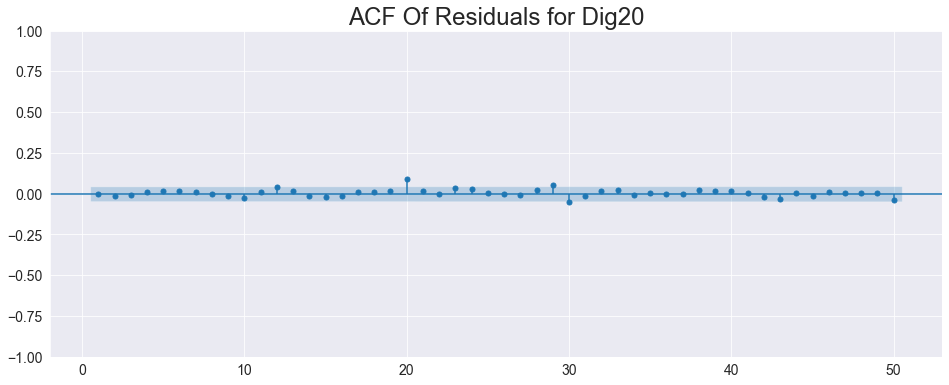

In [22]:
sgt.plot_acf(data20_resid_dataset.residuals, zero = False, lags = 50)
plt.title("ACF Of Residuals for Dig20",size=24)
plt.show()

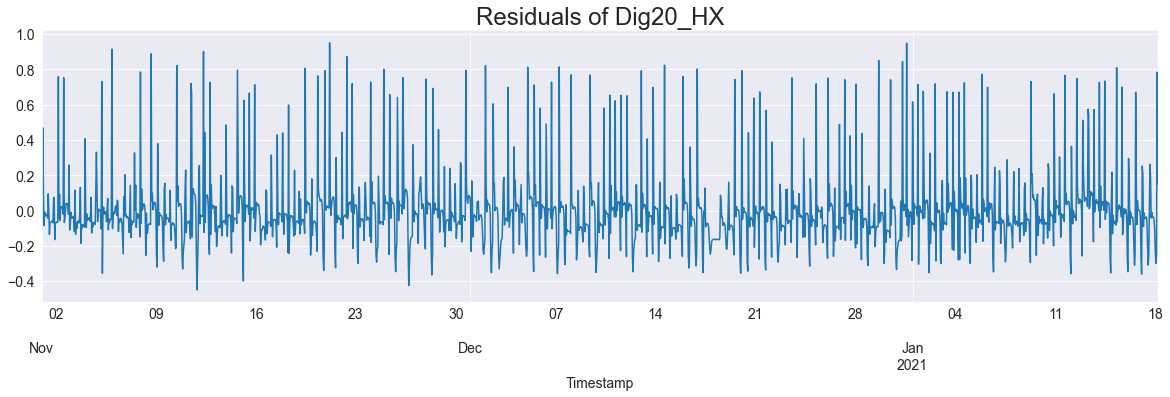

In [23]:
data20_resid_dataset.residuals.plot(figsize=(20,5))
plt.title("Residuals of Dig20_HX",size=24)
plt.show()

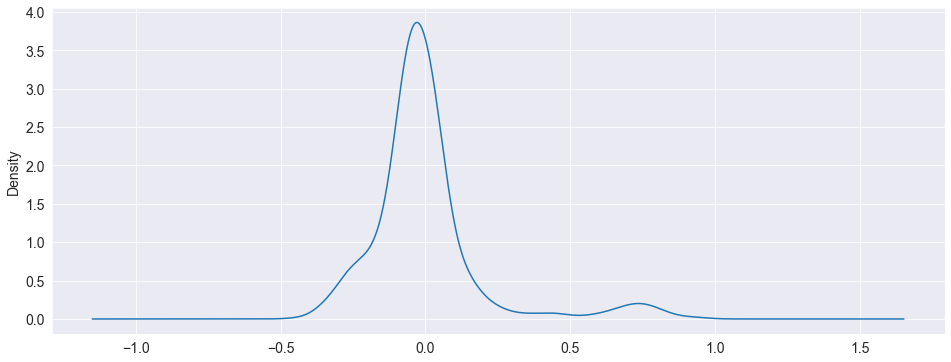

In [24]:
data20_resid_dataset.residuals.plot(kind='kde')
plt.show()

### Model Validation

In [25]:
start_date = "2021-01-18 05:00:00"
end_date = "2021-01-27 08:00:00"

In [26]:
df_pred = pd.DataFrame(model_auto.predict(n_periods = len(val_data20), index = val_data20.index))

In [27]:
scaler2 = MinMaxScaler()
scaler2.fit_transform(data20_twin1.Dig_20_HX.values.reshape(-1, 1))

array([[0.00294248],
       [0.01770792],
       [0.56817633],
       ...,
       [0.36615903],
       [0.07432569],
       [0.02623379]])

In [28]:
# Invert the scale of predictions
df_pred2 = scaler2.inverse_transform(df_pred.values.reshape(-1, 1))

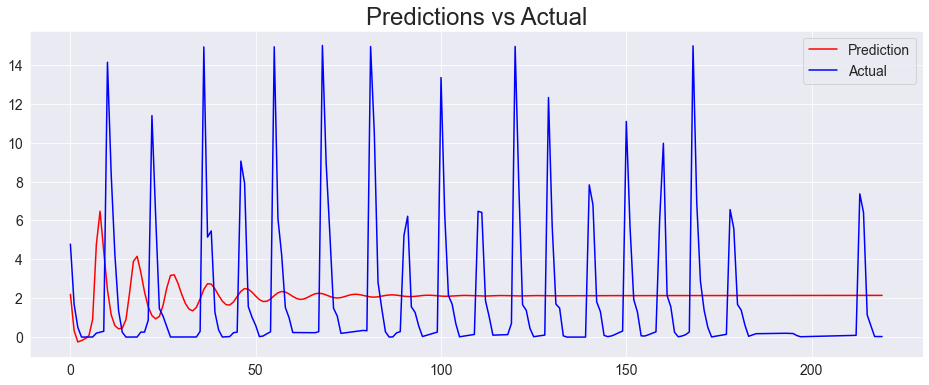

In [29]:
plt.plot(df_pred.index.to_numpy(), df_pred2, color = "red")
plt.plot(df_pred.index, data20_twin1.Dig_20_HX[start_date:end_date].to_numpy(), color = "blue")
plt.legend(['Prediction', 'Actual'])
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Performance Metrics

In [30]:
ndapred, ndaactual = df_pred, val_data20.Dig_20_HX.to_numpy()

In [31]:
print(ndapred.shape)
print(ndaactual.shape)

(220, 1)
(220,)


In [32]:
print("MAE: %.4f" %mean_absolute_error(ndaactual, ndapred))
print("RMSE: %.4f" %np.sqrt(mean_squared_error(ndaactual, ndapred)))

MAE: 0.1750
RMSE: 0.2417


In [33]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig20pred.npy", df_pred2)

### Forecast

In [34]:
fcast = pd.DataFrame(model_auto.predict(n_periods = len(test_data20), index = test_data20.index))

In [38]:
fcast = scaler2.inverse_transform(fcast.values.reshape(-1, 1))

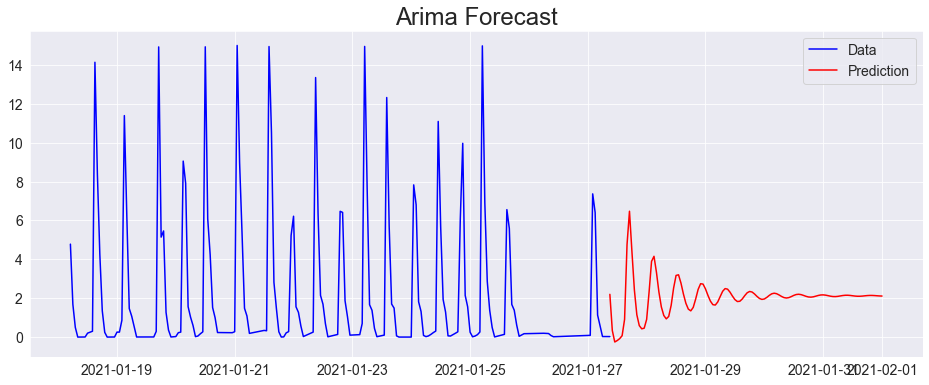

In [39]:
plt.plot(data20_twin1.index[1877:2098], data20_twin1.Dig_20_HX[1877:2098].to_numpy(), color = "blue")
plt.plot(test_data20.index, fcast, color = "red")
plt.legend(['Data', 'Prediction'])
plt.title("Arima Forecast", size = 24)
plt.show()

In [37]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig20fcast.npy", fcast)